In [1]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import warnings

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [2]:
os.chdir('../Data/')

In [3]:
os.listdir()

['products.csv',
 'orders.csv',
 '.DS_Store',
 'order_products__train.csv',
 'departments.csv',
 'aisles.csv',
 'order_products__prior.csv',
 'sample_submission.csv']

## Loading our Datasets

In [4]:
prod_df = pd.read_csv('products.csv')

In [5]:
ord_df = pd.read_csv('orders.csv')

In [6]:
ord_df.drop('eval_set', axis=1,inplace=True)

In [7]:
dep_df = pd.read_csv('departments.csv')

In [8]:
ais_df = pd.read_csv('aisles.csv')

We'll treat the prior as our training set and the train as our test set.  
Prior - 3214874 (our training set)  
Train - 131209 (our test set)

In [9]:
ord_prod_train_df = pd.read_csv('order_products__prior.csv')

In [10]:
ord_prod_test_df = pd.read_csv('order_products__train.csv')

Here we're combining the order/product information with user information by merging the `order_products` table with the `orders` table.

In [11]:
ord_prod_train_df = ord_prod_train_df.merge(ord_df, on='order_id')
ord_prod_test_df = ord_prod_test_df.merge(ord_df, on='order_id')

## Preparing our Test Data

### Organizing the data

Below I've created a new DataFrame that aggregared user-product info. I've also taken this as an opportunity to create a count of the number of orders for each product.

In [ ]:
df_user_product = (ord_prod_train_df.groupby(['product_id','user_id'],as_index=False) 
                              .agg({'order_id':'count'}) 
                              .rename(columns={'order_id':'num_ord_per_user_per_prod'}))

test_ids = ord_prod_test_df['user_id'].unique() 
df = df_user_product[df_user_product['user_id'].isin(test_ids)]
df.head()

,product_id,user_id,num_ord_per_user_per_prod
0,1,138,2
1,1,709,1
3,1,777,1
6,1,1052,2
9,1,1494,3


This is a DataFrame containing every single user_id, for every user_id you have every product they've ever ordered. The features of those products will be created mostly by grouping by user_id (i.e. values for features will be user_id specific and, within that, item specific).
One column for this DataFrame is labeled `in_cart` and will be our target variable during testing.

In [ ]:
test_carts = (ord_prod_test_df.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df = df.merge(test_carts, on='user_id')
df['in_cart'] = (df.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

### Quick look at our target

In [ ]:
orders = df.in_cart.value_counts()
print('Total unique combinations of product orders for total users =',orders[0]+orders[1])
print('Items not re-ordered in latest order =',orders[0])
print('Items re-ordered in latest order =',orders[1])
print('This means that there are 8474661 unique user_id/product_id combinations \
and that, of that, those users re-ordered 828824 of those items \
in their last order.')

In [ ]:
print('There are',df.user_id.nunique(), 'unique users.')

Ratio of non-re-orders v.s. re-orders.  
This shows a significant class imbalance.

In [ ]:
target_pcts = df.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

In [ ]:
pd.to_pickle(df,'00_merged_prod_order')

## Building Standard Functions

### Plotting  Features

In [17]:
def plot_features(df, alpha=.3, sample_size=500):
    """
    Takes a Dataframe as an input.
    Drops columns unnecessary for visualizations:
        product_id
        user_id
        latest_cart
    Plots engineered features.
    """
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(1000, random_state=44)) 
    plt.figure(figsize=(9,9))
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=alpha, edgecolor='none'))

### Train, val, Split
Due to the nature of our data we must be careful with how we split it and have therefore created our own function for doing so.


In [18]:
def get_user_split_data(df, val_size=.2, seed=42):
    """
    We will create an 80/20 split of users and take all orders for those users.  
    Default Values:
        Test Size:
            80 - Training Data
            20 - Validation Data
        Random Seed:
            42
    From that we will take the in_cart column created in the 'Preparing our
    Test Data' section which will be used as our target variable.
    
    test_size - takes any value between 0 and 1
    seed - takes any integer.
    Outputs:
    X_tr, X_val, y_tr, y_val
    """

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    # Multiplies the number of observations (user_id's) by the test size
    # to get a list of validation users.
    val_users = rs.choice(total_users, 
                   size=int(total_users.shape[0] * val_size), 
                   replace=False)

    df_tr = df[~df['user_id'].isin(val_users)]
    df_val = df[df['user_id'].isin(val_users)] 

    y_tr, y_val = df_tr['in_cart'], df_val['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1) 
    X_val = df_val.drop(['product_id','user_id','latest_cart','in_cart'],axis=1)

    return X_tr, X_val, y_tr, y_val

### Show All

In [19]:
def plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val):
    
    plot_features(df)
    plt.show()
    
    features = df.drop(['product_id','user_id',
                        'latest_cart'],axis=1).columns
    
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_tr, y_tr)
    vals = pd.DataFrame(lr.predict(X_val))[0].value_counts()
    coefs = [round(x,4) for x in lr.coef_.tolist()[0]]
    print('Our score is',f1_score(lr.predict(X_val), y_val))
    print('The coefficients are',list(zip(features,coefs)))
    print('And we\'ve predicted',vals[0],'non-re-orders and',
    vals[1],'re-orders.')

## Feature Engineering

Our feature engineering began in the 'Organizing data section.  
We will visualize that first feature below and begin creating new features.

<Figure size 648x648 with 0 Axes>

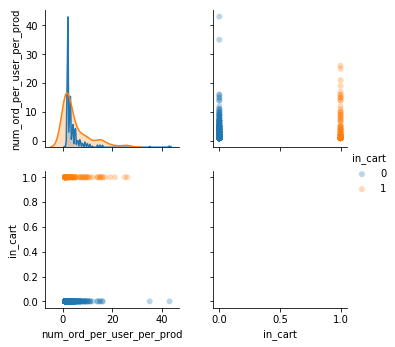

Our score is 0.0864409013045197
The coefficients are [('num_ord_per_user_per_prod', 0.1422)]
And we've predicted 1675585 non-re-orders and 16723 re-orders.


In [20]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

As you can see, we're setting the bar pretty low.

## Product Features
`product_total_orders` and `product_avg_add_to_cart_order`

In [21]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (ord_prod_train_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df = df.merge(df_prod_features, on='product_id')

`product_total_orders` had some pretty enourmous rightward skew that ultimately resulted in the model producing 0 positive predictions. As a result I took the log base 2 transformation to punish outliers.  
Note that I attempted a log base 10 transformation but log base 2 had better results.

In [22]:
df.product_total_orders = np.log2(df.product_total_orders)

<Figure size 648x648 with 0 Axes>

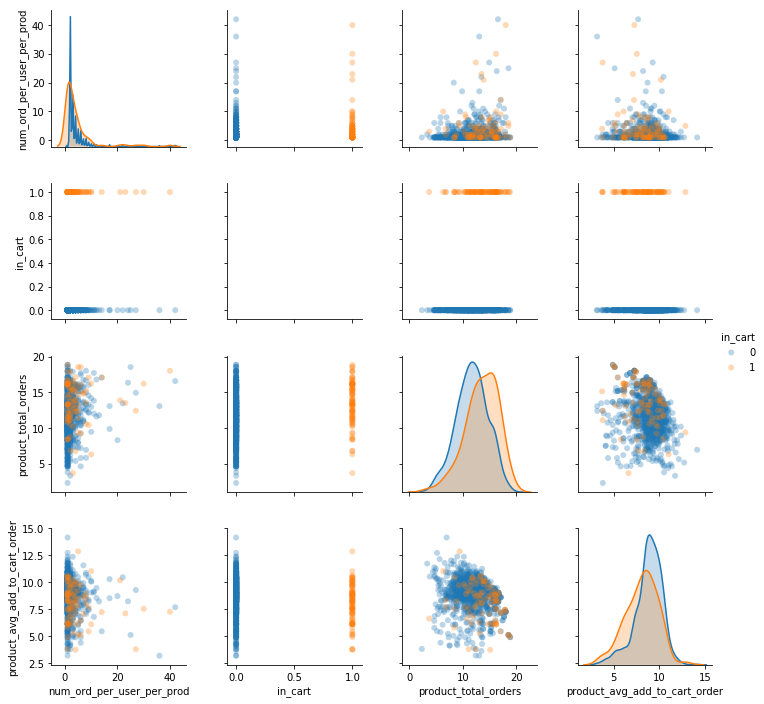

Our score is 0.08767651253688119
The coefficients are [('num_ord_per_user_per_prod', 0.123), ('in_cart', 0.0795), ('product_total_orders', -0.1667)]
And we've predicted 1679289 non-re-orders and 16445 re-orders.


In [23]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User Features
`'user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'`

In [24]:
user_features = ['user_total_orders','user_avg_cartsize',
                 'user_total_products','user_avg_days_since_prior_order']

df_user_features = (ord_prod_train_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_id',
                         ['nunique', # user_total_orders
                        (lambda x: x.shape[0] / x.nunique())]), # user_avg_cartsize
                        ('product_id','nunique'), # user_total_products
                        ('days_since_prior_order','mean')]))) # user_avg_days_since_prior_order
df_user_features.columns = ['user_id'] + user_features
df = df.merge(df_user_features, on='user_id')

<Figure size 648x648 with 0 Axes>

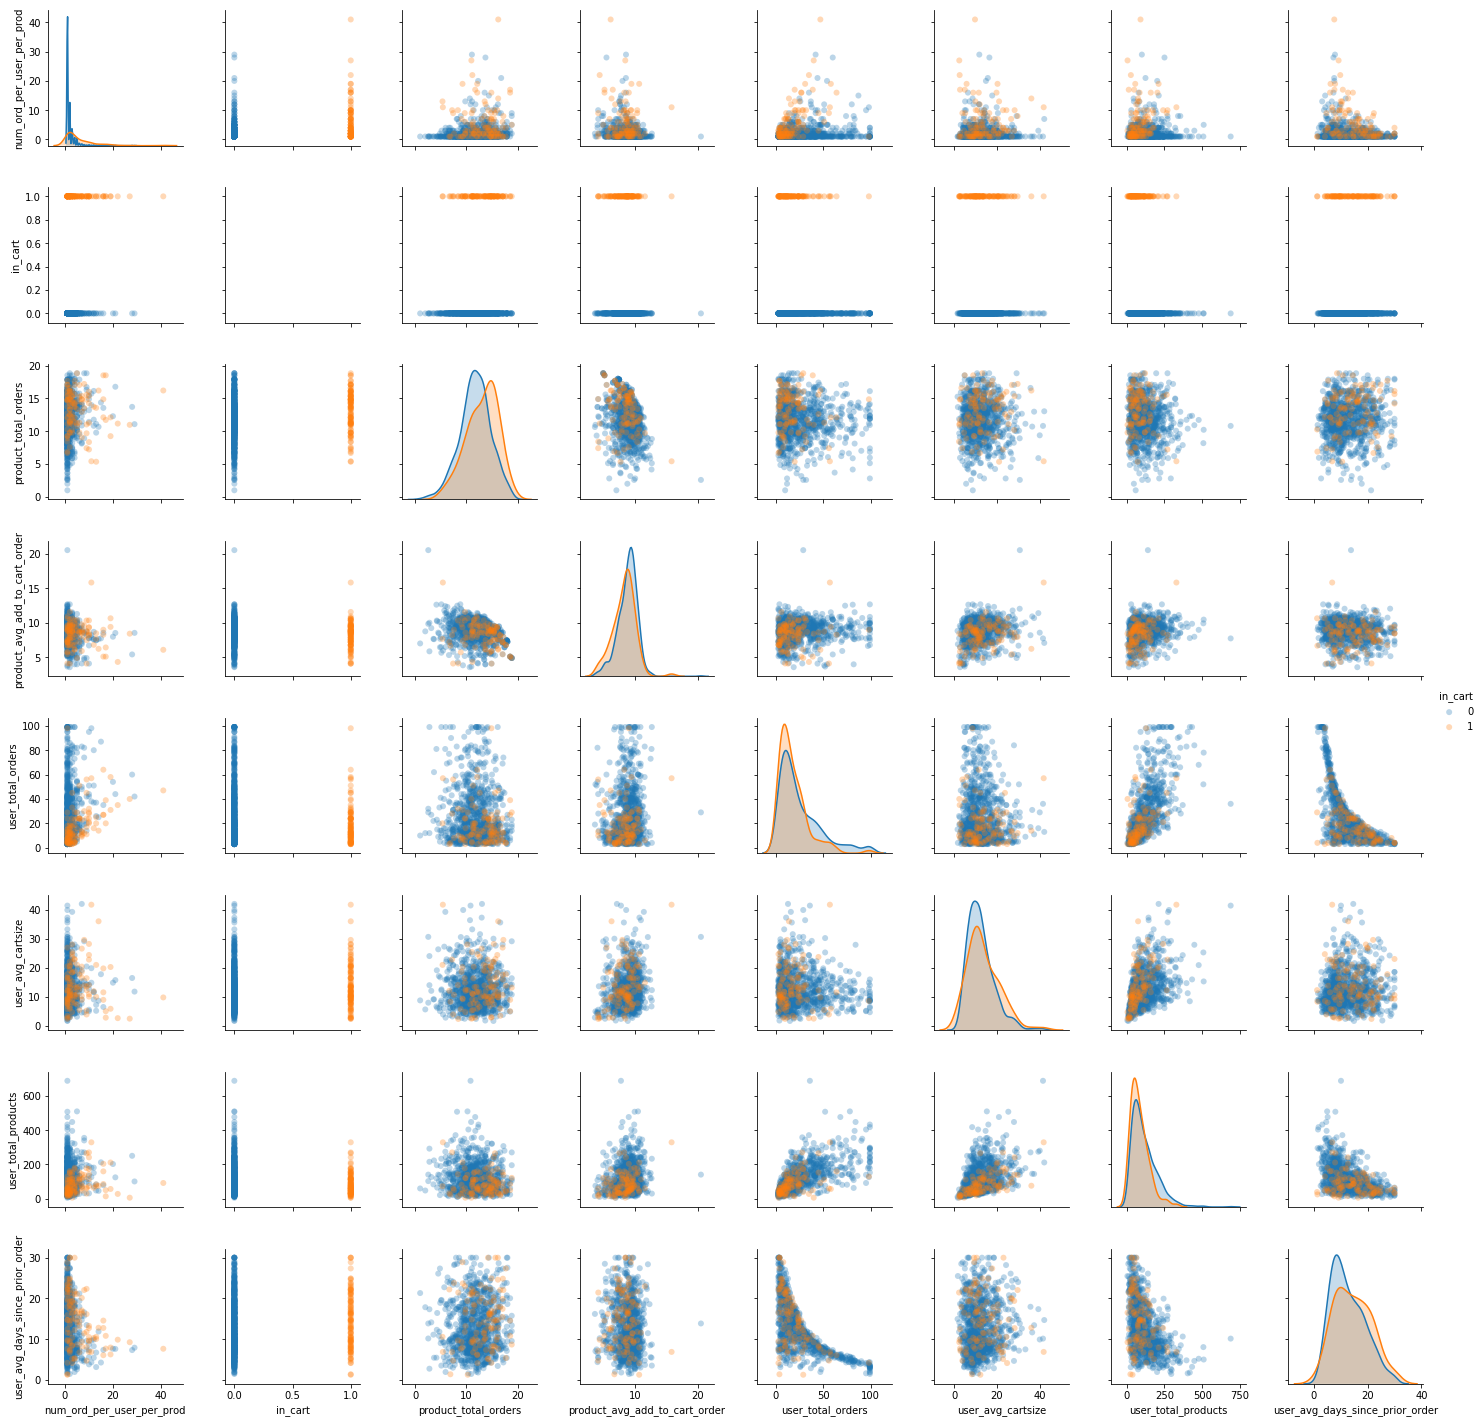

Our score is 0.12110314302130103
The coefficients are [('num_ord_per_user_per_prod', 0.1809), ('in_cart', 0.0726), ('product_total_orders', -0.1338), ('product_avg_add_to_cart_order', -0.0231), ('user_total_orders', 0.0447), ('user_avg_cartsize', -0.0054), ('user_total_products', -0.0016)]
And we've predicted 1675015 non-re-orders and 20719 re-orders.


In [25]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User-Product features

In [26]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (ord_prod_train_df.groupby(
                        ['product_id','user_id'],as_index=False) \
                        .agg(OrderedDict(
                        [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df = df.merge(df_user_prod_features,on=['user_id','product_id'])
df['user_product_order_freq'] = df['num_ord_per_user_per_prod'] / df['user_total_orders'] 

<Figure size 648x648 with 0 Axes>

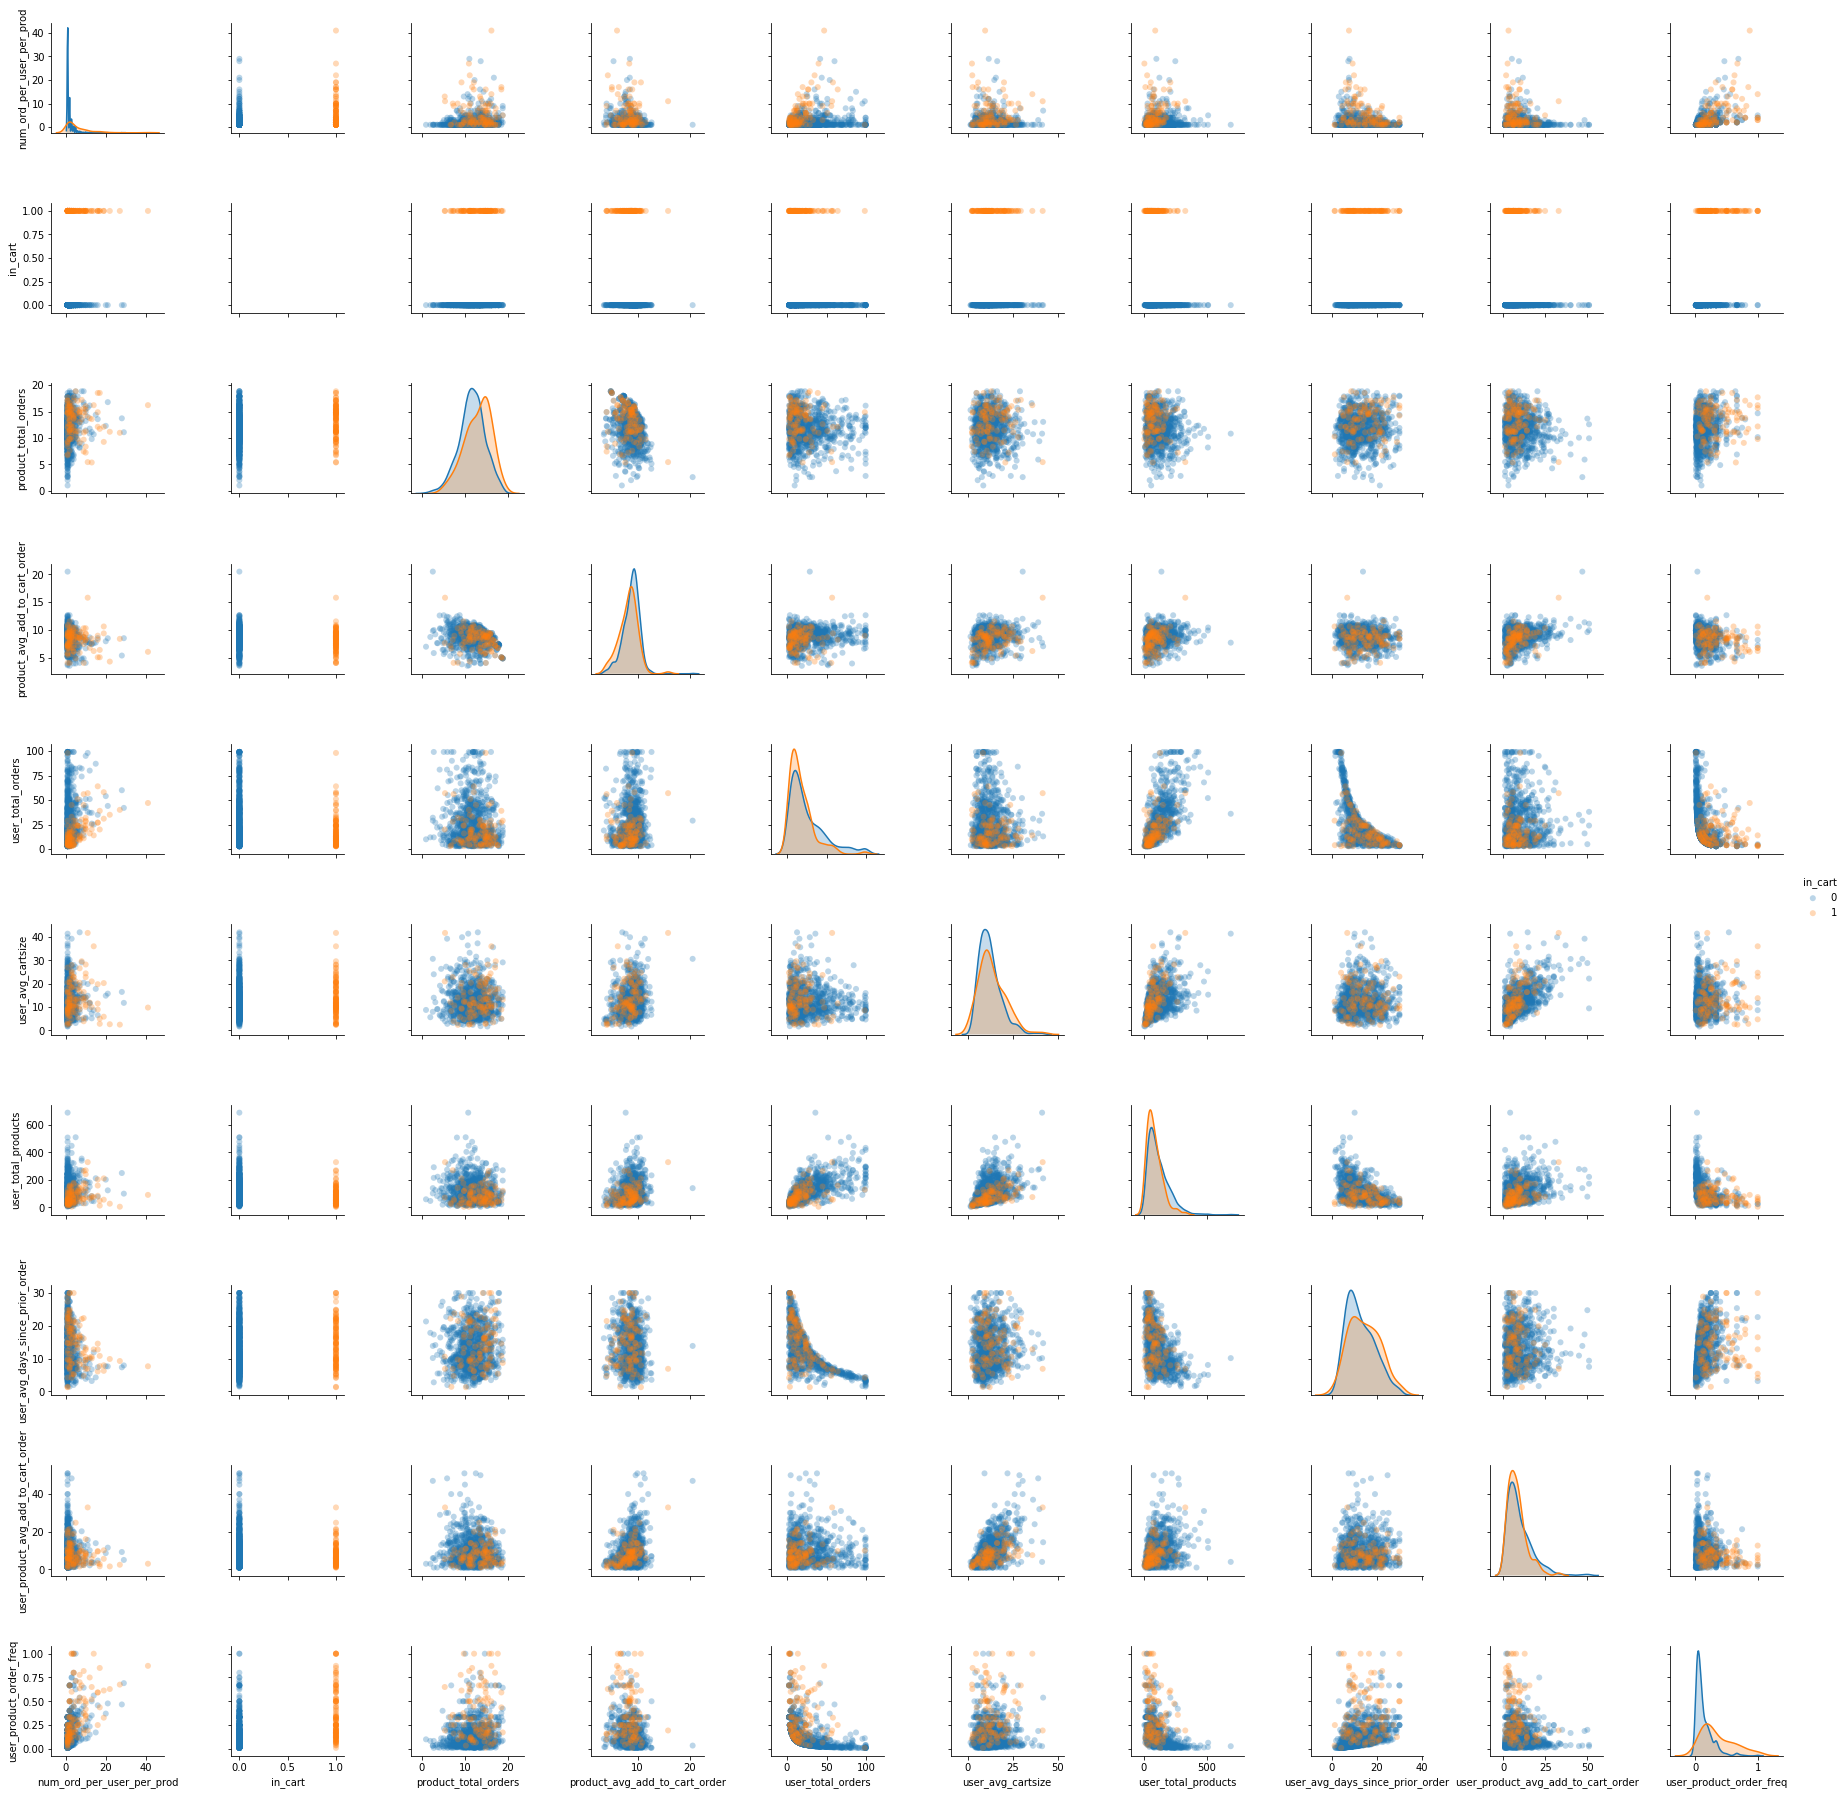

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our score is 0.22880326889347186
The coefficients are [('num_ord_per_user_per_prod', 0.0601), ('in_cart', 0.0339), ('product_total_orders', -0.1371), ('product_avg_add_to_cart_order', -0.0081), ('user_total_orders', 0.0142), ('user_avg_cartsize', -0.0016), ('user_total_products', -0.018), ('user_avg_days_since_prior_order', 0.0015), ('user_product_avg_add_to_cart_order', 3.6194)]
And we've predicted 1655455 non-re-orders and 40279 re-orders.


In [27]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)